In [2]:
import numpy as np
from numpy import linalg
from numpy.linalg import *
import matplotlib.pyplot as plt
import math
from scipy import linalg as la

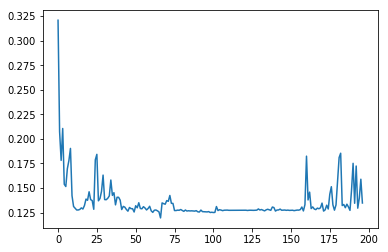

[[ 10094.03129147]]


In [836]:
#BASIC LEARNING ALGORITHM

def initialize(n,r):
    # initialization
    # n is dimension of x vector 
    # r is dimension of u
    p = n + r # dimension of theta
    A_est = 10*np.random.rand(n,n)
    spectrum=max(abs(np.linalg.eigvals(A_est)))
    A_est=A_est/spectrum
    assert A_est.shape == (n,n)
    
    B_est = 5*np.random.rand(n,r)
    A= 10*np.random.rand(n,n)
    spectrum=max(abs(np.linalg.eigvals(A)))
    A=A/spectrum
    assert A.shape == (n,n)
    B= 5*np.random.rand(n,r)
    
    return A,B,A_est,B_est

def ricatti(A,B,Q,R):
    K=la.solve_discrete_are(A, B, Q, R, e=None, s=None, balanced=True)
    L=-np.linalg.inv(B.transpose().dot(K.dot(B))+R).dot(B.transpose().dot(K.dot(A)))
    return L

# a trial collects data by walking through trial number of updates on x and u and stores in phi matrix 
# that is a concatenation of u and x, where u is obtained by ricatti L matrix everytime, and get x by state 
# update equation
# returns phi matrix, which is the concatenation of u and x during this trial
# and returns y, which is our 'target' vector

def trial(ltrial,n,r,A,B,L,stepcost):
    phi=np.zeros((ltrial,n+r))
    Y=np.zeros((ltrial,n))
    x_next=np.zeros((n,1))
    for k in range(ltrial+1):
        if k<ltrial: 
            for i in range(n): phi[k,r+i]=x_next[i,0]
        x=x_next
        u= np.dot(L,x)
        if k<ltrial: 
            for i in range(r):
                phi[k,i]=u[i,0]
            stepcost.append(x.transpose().dot(x)+u.transpose().dot(u))
        w = np.random.normal(0, 0.1, (n,1))
        x_next=A.dot(x)+B.dot(u)+w
        if k>0: 
            for i in range(n): Y[k-1,i]=x_next[i,0]
    stepcost.append(x_next.transpose().dot(x_next)[0,0])
    return phi,Y

# get closed form for theta - which is our parameters of A and B
def compute_theta(phi,Y):
    # phi is of shape [ltrial,r + n] : [u, x]
    # Y is of shape [ltrial x n]: each row is [x]
    # inv([ltrial,r + n].T.dot([ltrial,r + n])) = [r+n, r+n].dot([r+n,ltrial]).dot([ltrial x n]) = [r+n,n]
    # returns shape of [n+r, n] = [A,
    #                              B] 
    return np.linalg.inv(phi.transpose().dot(phi)).dot(phi.transpose()).dot(Y)

def get_AB(theta,r):
    A=theta[r:].transpose()
    B=theta[:r].transpose()
    return A, B

def episode(A,B,A_est,B_est,n,r,ltrial,stepcost):
    Q = np.eye(n)
    R = np.eye(r)
    L_est=ricatti(A_est,B_est,Q,R)
    L=ricatti(A,B,Q,R)
    phi,Y=trial(ltrial,n,r,A,B,L_est,stepcost)
    theta=compute_theta(phi,Y)
    A_est,B_est=get_AB(theta,r)
    norm=np.linalg.norm(L_est-L)
    return A_est,B_est,norm

nruns=1 #number of times to run the algorithm
n=5
r=3
ltrial=50
nepisodes=10 #if running a given number of episodes rather than waiting for convergence
maxstep=10000 #maximum number of steps before exiting convergence loop
stepcost=[]
error=0.1 #convergence criteria (in norm of L)


for s in range(nruns):
    A,B,A_est,B_est=initialize(n,r)
    Norm=[]
    #for ep in range(nepisodes): #uncomment to run a given number of episodes rather than wait for convergence
    while norm>error and len(stepcost)<maxstep: #comment if running until convergence
        A_est,B_est,norm=episode(A,B,A_est,B_est,n,r,ltrial,stepcost)
        Norm.append(norm)
    plt.plot(Norm)

plt.show()
avgcost=np.mean(stepcost)
print(avgcost)

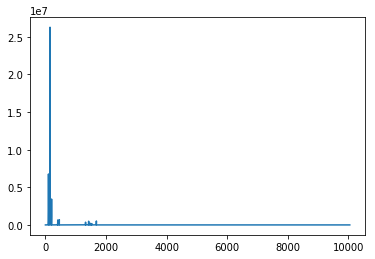

array([[  1.01414732e+08]])

In [837]:
plt.plot(stepcost)
plt.show()
print(np.sum(stepcost))

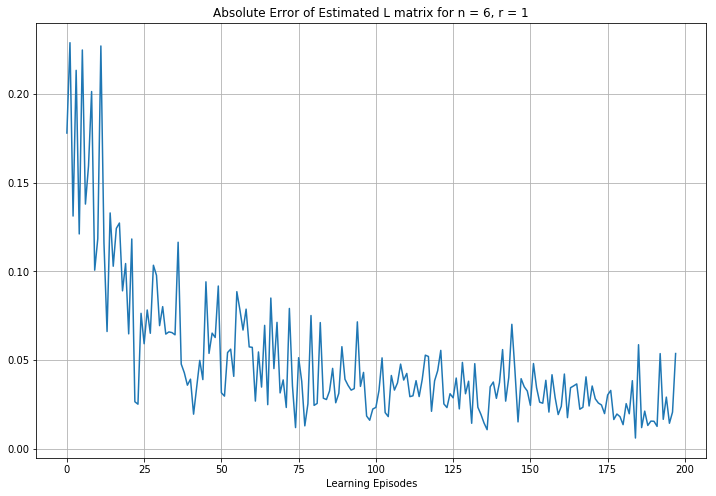

[[-0.19272225 -0.22146644 -0.24310017 -0.2745505  -0.21299317 -0.22119562]]
[[-0.21212513 -0.20985977 -0.28218304 -0.25518798 -0.19330477 -0.23037418]]


In [4]:
#OPTIMAL LEARNING ALGORITHM R=1
def initialize(n,r):
    # initialization, n is dimension of x , r is dimension of u
    #algorithm initializes A,A_est,B and B_est randomly
    A_est = np.random.rand(n,n)
    spectrum=max(abs(np.linalg.eigvals(A_est)))
    A_est=A_est/spectrum
    assert A_est.shape == (n,n)
    
    B_est = np.random.rand(n,r)
    
    A= np.random.rand(n,n)
    spectrum=max(abs(np.linalg.eigvals(A)))
    A=A/spectrum
    assert A.shape == (n,n)
    
    B= np.random.rand(n,r)
            
    return A,B,A_est,B_est

def ricatti(A,B,Q,R):
    #solves the ricatti equation given A,B,Q and R, returns the appropriate control law L
    K=la.solve_discrete_are(A, B, Q, R, e=None, s=None, balanced=True)
    L=-np.linalg.inv(B.transpose().dot(K.dot(B))+R).dot(B.transpose().dot(K.dot(A)))
    return L

def trial(ltrial,A,B,j):
    x_next=np.zeros((n,1))
    for k in range(ltrial+1):
        x = x_next
        if ltrial-k==j: u=np.ones((r,1))
        if ltrial-k!=j: u=np.zeros((r,1))
        w = np.random.normal(0, 0.1, (n,1))
        x_next = A.dot(x) + B.dot(u) + w
        psi = [u,x]
    return psi,x_next.transpose()

def explore(A,B,A_est,B_est,n,r,nepisodes):
    ltrial=int(n/r)
    ntrials=n+r
    m=0
    phi = np.zeros((ntrials*nepisodes,n+r))
    Y = np.zeros((ntrials*nepisodes,n))
    for i in range(nepisodes):
        for j in range(ntrials):
            psi,y=trial(ltrial+1,A,B,j)
            for i in range(r): phi[m,i]=psi[0][i,0]
            for i in range(n): 
                phi[m,i+r]=psi[1][i,0]
                Y[m,i]=y[0,i]
            m+=1
    theta = compute_theta(phi,Y)
    A_est,B_est=get_AB(theta,r)
    
    Q = np.eye(n)
    R = np.eye(r)
    L=ricatti(A,B,Q,R)
    L_est=ricatti(A_est,B_est,Q,R)
    norm=np.linalg.norm(L_est-L)
    return A_est,B_est,norm

def compute_theta(phi,Y):
    return np.linalg.inv(phi.transpose().dot(phi)).dot(phi.transpose()).dot(Y)

def get_AB(theta,r):
    A=theta[r:].transpose()
    B=theta[:r].transpose()
    return A, B

n=6
r=1
nepisodes=200
Norm=[]
for ep in range(2,nepisodes):
    A,B,A_est,B_est=initialize(n,r)
    A_est,B_est,norm=explore(A,B,A_est,B_est,n,r,ep)
    Norm.append(norm)

%matplotlib inline
import seaborn
seaborn.mpl.rcParams['figure.figsize'] = (12.0, 8.0)
seaborn.mpl.rcParams['savefig.dpi'] = 90


plt.grid(True)
plt.xlabel('Learning Episodes')
plt.title('Absolute Error of Estimated L matrix for n = 6, r = 1')
plt.plot(Norm)
plt.show()

Q = np.eye(n)
R = np.eye(r)
L=ricatti(A,B,Q,R)
L_est=ricatti(A_est,B_est,Q,R)
print(L)
print(L_est)

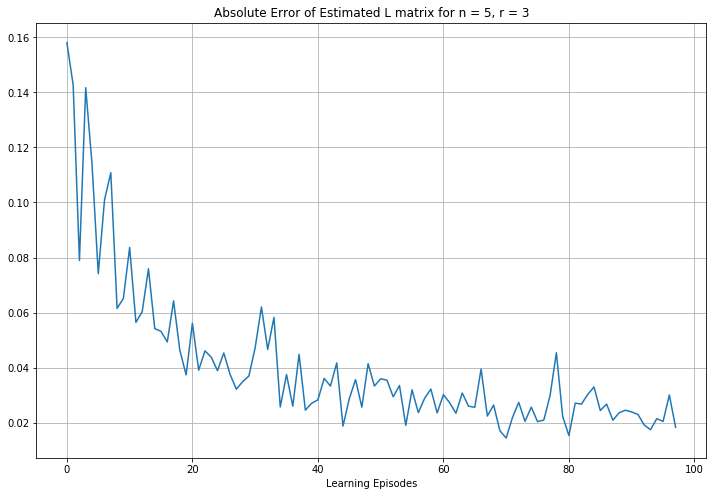

In [6]:
#OPTIMAL LEARNING ALGORITHM R>1
def initialize(n,r):
    # initialization, n is dimension of x , r is dimension of u
    #algorithm initializes A,A_est,B and B_est randomly
    A_est = np.random.rand(n,n)
    spectrum=max(abs(np.linalg.eigvals(A_est)))
    A_est=A_est/spectrum
    assert A_est.shape == (n,n)
    
    B_est = np.random.rand(n,r)
    
    A= np.random.rand(n,n)
    spectrum=max(abs(np.linalg.eigvals(A)))
    A=A/spectrum
    assert A.shape == (n,n)
    
    B= np.random.rand(n,r)
            
    return A,B,A_est,B_est

def ricatti(A,B,Q,R):
    #solves the ricatti equation given A,B,Q and R, returns the appropriate control law L
    K=la.solve_discrete_are(A, B, Q, R, e=None, s=None, balanced=True)
    L=-np.linalg.inv(B.transpose().dot(K.dot(B))+R).dot(B.transpose().dot(K.dot(A)))
    return L

def trial(ltrial,A,B,j,stepcost):
    x_next=np.zeros((n,1))
    for k in range(ltrial):
        x = x_next
        u=np.zeros((r,1))
        stepcost.append(x.transpose().dot(x)+u.transpose().dot(u)[0,0])
        if k==ltrial-(j/r): u[j%r,0]=1
        w = np.random.normal(0, 0.1, (n,1))
        x_next = A.dot(x) + B.dot(u) + w
    psi = [u,x]
    stepcost.append(x_next.transpose().dot(x_next)[0,0])
    return psi,x_next.transpose()

def explore(A,B,A_est,B_est,n,r,nepisodes,stepcost):
    ltrial=n+r
    ntrials=ltrial*r
    m=0
    phi = np.zeros((ntrials*nepisodes,n+r))
    Y = np.zeros((ntrials*nepisodes,n))
    for i in range(nepisodes):
        for j in range(ntrials):
            psi,y=trial(ltrial,A,B,j,stepcost)
            for i in range(r): phi[m,i]=psi[0][i,0]
            for i in range(n): 
                phi[m,i+r]=psi[1][i,0]
                Y[m,i]=y[0,i]
            m+=1
    theta = compute_theta(phi,Y)
    A_est,B_est=get_AB(theta,r)
    
    Q = np.eye(n)
    R = np.eye(r)
    L=ricatti(A,B,Q,R)
    L_est=ricatti(A_est,B_est,Q,R)
    norm=np.linalg.norm(L_est-L)
    norm1=np.linalg.norm(A_est-A)
    norm2=np.linalg.norm(B_est-B)
    return A_est,B_est,norm,norm1,norm2

def compute_theta(phi,Y):
    return np.linalg.inv(phi.transpose().dot(phi)).dot(phi.transpose()).dot(Y)

def get_AB(theta,r):
    A=theta[r:].transpose()
    B=theta[:r].transpose()
    return A, B

n=5
r=3
nepisodes=100

Norm=[]
Norm1=[]
Norm2=[]
stepcost=[]
for ep in range(2,nepisodes):
    A,B,A_est,B_est=initialize(n,r)
    A_est,B_est,norm,norm1,norm2=explore(A,B,A_est,B_est,n,r,ep,stepcost)
    Norm.append(norm)
    Norm1.append(norm1)
    Norm2.append(norm2)

    
%matplotlib inline
import seaborn
seaborn.mpl.rcParams['figure.figsize'] = (12.0, 8.0)
seaborn.mpl.rcParams['savefig.dpi'] = 90


plt.grid(True)
plt.xlabel('Learning Episodes')
plt.title('Absolute Error of Estimated L matrix for n = 5, r = 3')
plt.plot(Norm)
plt.show()


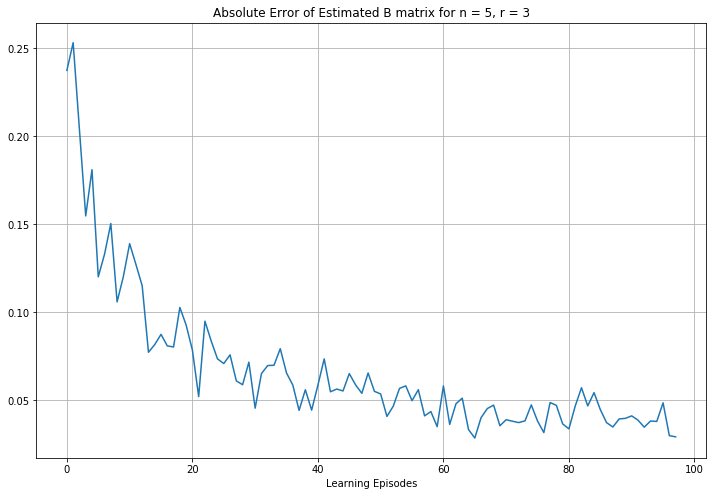

In [25]:
plt.grid(True)
plt.xlabel('Learning Episodes')
plt.title('Absolute Error of Estimated B matrix for n = 5, r = 3')

plt.plot(Norm2)
plt.grid(True)
plt.show()

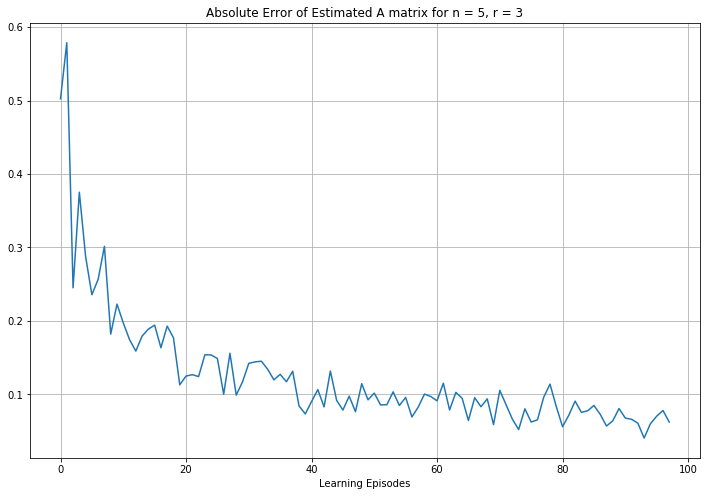

In [26]:
plt.grid(True)
plt.xlabel('Learning Episodes')
plt.title('Absolute Error of Estimated A matrix for n = 5, r = 3')

plt.plot(Norm1)
plt.grid(True)
plt.show()

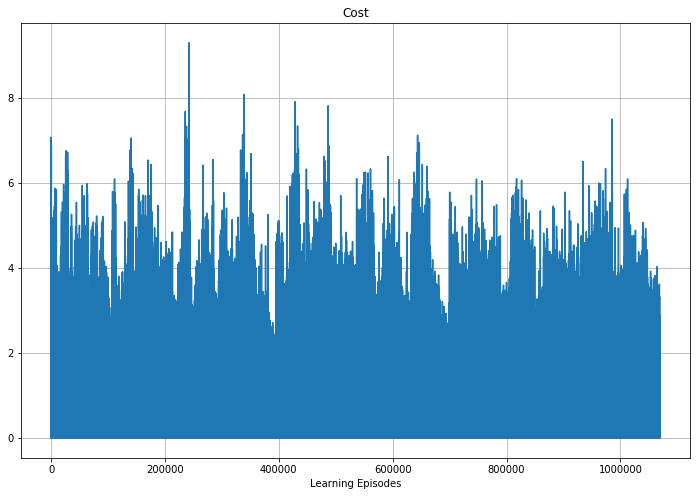

In [7]:
plt.grid(True)
plt.xlabel('Learning Episodes')
plt.title('Cost')
plt.plot(stepcost)
plt.show()

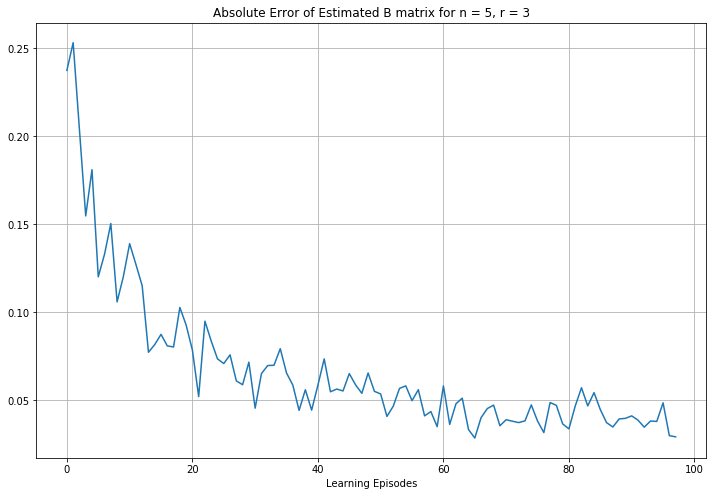

In [8]:
plt.grid(True)
plt.xlabel('Learning Episodes')
plt.title('Absolute Error of Estimated B matrix for n = 5, r = 3')

plt.plot(Norm2)
plt.show()

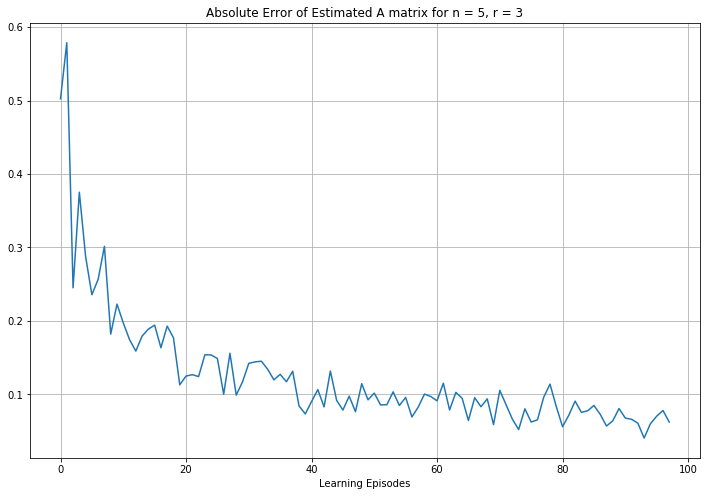

In [9]:
plt.grid(True)
plt.xlabel('Learning Episodes')
plt.title('Absolute Error of Estimated A matrix for n = 5, r = 3')

plt.plot(Norm1)
plt.show()

0.00978558307918
11.4066773393
0.00146466756806
0.000148388720044
7.88232812354e-11


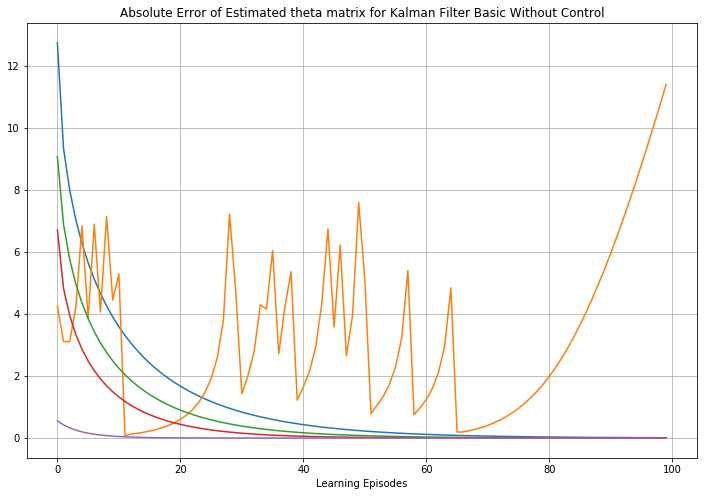

In [10]:
#Kalman Filter Basic Without Control

n=7
noise=0.01
meantheta=0
vartheta=10
covx=noise*np.identity(n)
meanx=1*np.ones(n)
covnoise=0.001*np.identity(n)
meannoise=np.zeros(n)
covnoise2=np.zeros((n+1,n+1))
covnoise2[0:n,0:n]=0.01*np.identity(n)
meannoise2=np.zeros(n+1)

ntrials=5
for s in range(ntrials):
    #initializing
    A=np.random.rand(n,n)
    theta_real=np.random.normal(meantheta,vartheta)
    A_real= np.zeros((n+1,n+1))
    A_real[0:n,0:n]=A+theta_real*np.eye(n)
    A_real[n,n]=1
    x_real=np.matrix(np.random.multivariate_normal(meanx,covx)).transpose()
    y_real=np.zeros((n+1,1))
    y_real[0:n]=x_real
    y_real[n]=theta_real
    C_real=np.zeros((n,n+1))
    C_real[0:n,0:n]=np.eye(n)
    y_est=np.zeros((n+1,1))
    y_est[0:n]=np.matrix(meanx).transpose()
    y_est[n]=meantheta
    cov_est=np.zeros((n+1,n+1))
    cov_est[0:n,0:n]=covx
    cov_est[n,n]=vartheta

#loop
    nsteps=100
    error=[]
    for k in range(nsteps):
        noise=np.matrix(np.random.multivariate_normal(meannoise,covnoise)).transpose()
        y_obs=C_real.dot(y_real)+noise
        y_est=y_est+cov_est.dot(C_real.transpose()).dot(np.linalg.inv(C_real.dot(cov_est).dot(C_real.transpose())+covnoise)).dot(y_obs-C_real.dot(y_est))
        cov_est=cov_est-cov_est.dot(C_real.transpose()).dot(np.linalg.inv(C_real.dot(cov_est).dot(C_real.transpose())+covnoise)).dot(C_real).dot(cov_est)
        noise=np.matrix(np.random.multivariate_normal(meannoise2,covnoise2)).transpose()
        y_real=A_real.dot(y_real)+noise
        A_est= np.zeros((n+1,n+1))
        A_est[0:n,0:n]=A+y_est[n,0]*np.eye(n)
        A_est[n,n]=1
        y_est=A_est.dot(y_est)
        A_est[0:n,n:(n+1)]=y_est[0:n]
        cov_est=A_est.dot(cov_est).dot(A_est.transpose())+covnoise2
        error.append(abs(theta_real-y_est[n,0]))
    plt.plot(error)
    print(error.pop())

plt.grid(True)
plt.xlabel('Learning Episodes')
plt.title('Absolute Error of Estimated theta matrix for Kalman Filter Basic Without Control')
   
plt.show()

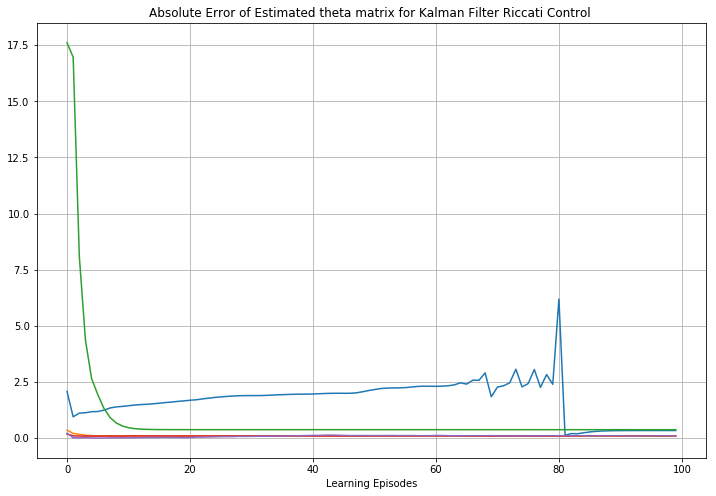

In [19]:
#Kalman Filter with Riccati Control 

n=7
r=3
noise=0.01
meantheta=0
vartheta=1
covx=noise*np.identity(n)
meanx=1*np.ones(n)
covnoise=0.001*np.identity(n)
meannoise=np.zeros(n)
covnoise2=np.zeros((n+1,n+1))
covnoise2[0:n,0:n]=0.01*np.identity(n)
meannoise2=np.zeros(n+1)

def ricatti(A,B,Q,R):
    #solves the ricatti equation given A,B,Q and R, returns the appropriate control law L
    K=la.solve_discrete_are(A, B, Q, R, e=None, s=None, balanced=True)
    L=-np.linalg.inv(B.transpose().dot(K.dot(B))+R).dot(B.transpose().dot(K.dot(A)))
    return L

ntrials=5
for s in range(ntrials):
    #initializing
    A=np.random.rand(n,n)
    B=np.random.rand(n,r)
    theta_real=np.random.normal(meantheta,vartheta)
    A_real= np.zeros((n+1,n+1))
    A_real[0:n,0:n]=A+theta_real*np.eye(n)
    A_real[n,n]=1
    B_real=np.zeros((n+1,r+1))
    B_real[0:n,0:r]=B+theta_real*np.eye(n,r)
    x_real=np.matrix(np.random.multivariate_normal(meanx,covx)).transpose()
    y_real=np.zeros((n+1,1))
    y_real[0:n]=x_real
    y_real[n]=theta_real
    C_real=np.zeros((n,n+1))
    C_real[0:n,0:n]=np.eye(n)
    y_est=np.zeros((n+1,1))
    y_est[0:n]=np.matrix(meanx).transpose()
    y_est[n]=meantheta
    cov_est=np.zeros((n+1,n+1))
    cov_est[0:n,0:n]=covx
    cov_est[n,n]=vartheta
    Q=np.eye(n)
    R=np.eye(r)
    L=ricatti(A+theta_real*np.eye(n),B+theta_real*np.eye(n,r),Q,R)
    
    #loop
    nsteps=100
    error=[]
    errorL=[]
    for k in range(nsteps):
        noise=np.matrix(np.random.multivariate_normal(meannoise,covnoise)).transpose()
        y_obs=C_real.dot(y_real)+noise
        y_est=y_est+cov_est.dot(C_real.transpose()).dot(np.linalg.inv(C_real.dot(cov_est).dot(C_real.transpose())+covnoise)).dot(y_obs-C_real.dot(y_est))
        cov_est=cov_est-cov_est.dot(C_real.transpose()).dot(np.linalg.inv(C_real.dot(cov_est).dot(C_real.transpose())+covnoise)).dot(C_real).dot(cov_est)
        A_est= np.zeros((n+1,n+1))
        A_est[0:n,0:n]=A+y_est[n,0]*np.eye(n)
        A_est[n,n]=1
        B_est= np.zeros((n+1,r+1))
        B_est[0:n,0:r]=B+y_est[n,0]*np.eye(n,r)
        L_est=ricatti(A_est[0:n,0:n],B_est[0:n,0:r],Q,R)
        u_est=L_est.dot(y_est[0:n])
        u=np.zeros((r+1,1))
        u[0:r]=u_est
        noise=np.matrix(np.random.multivariate_normal(meannoise2,covnoise2)).transpose()
        y_real=A_real.dot(y_real)+B_real.dot(u)+noise
        y_est=A_est.dot(y_est)+B_est.dot(u)
        A_est[0:n,n:(n+1)]=y_est[0:n]+np.eye(n,r).dot(u[0:r])
        cov_est=A_est.dot(cov_est).dot(A_est.transpose())+covnoise2
        error.append(abs(theta_real-y_est[n,0]))
        errorL.append(np.linalg.norm(L_est-L))
    #plt.plot(error)
    plt.plot(errorL)
    
plt.grid(True)
plt.xlabel('Learning Episodes')
plt.title('Absolute Error of Estimated theta matrix for Kalman Filter Riccati Control ')

plt.show()

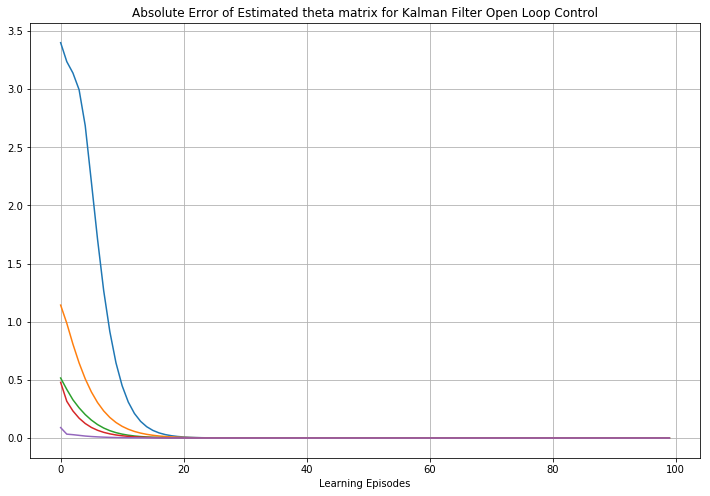

In [24]:
#Kalman Filter with Open Loop Control 

n=7
r=3
noise=0.01
meantheta=0
vartheta=1
covx=noise*np.identity(n)
meanx=1*np.ones(n)
covnoise=0.001*np.identity(n)
meannoise=np.zeros(n)
covnoise2=np.zeros((n+1,n+1))
covnoise2[0:n,0:n]=0.01*np.identity(n)
meannoise2=np.zeros(n+1)
Q=np.eye(n)
R=np.eye(r)

def ricatti(A,B,Q,R):
    #solves the ricatti equation given A,B,Q and R, returns the appropriate control law L
    K=la.solve_discrete_are(A, B, Q, R, e=None, s=None, balanced=True)
    L=-np.linalg.inv(B.transpose().dot(K.dot(B))+R).dot(B.transpose().dot(K.dot(A)))
    return L

ntrials=5
for s in range(ntrials):
    #initializing
    A=np.random.rand(n,n)
    B=np.random.rand(n,r)
    theta_real=np.random.normal(meantheta,vartheta)
    A_real= np.zeros((n+1,n+1))
    A_real[0:n,0:n]=A+theta_real*np.eye(n)
    A_real[n,n]=1
    B_real=np.zeros((n+1,r+1))
    B_real[0:n,0:r]=B+theta_real*np.eye(n,r)
    x_real=np.matrix(np.random.multivariate_normal(meanx,covx)).transpose()
    y_real=np.zeros((n+1,1))
    y_real[0:n]=x_real
    y_real[n]=theta_real
    C_real=np.zeros((n,n+1))
    C_real[0:n,0:n]=np.eye(n)
    y_est=np.zeros((n+1,1))
    y_est[0:n]=np.matrix(meanx).transpose()
    y_est[n]=meantheta
    cov_est=np.zeros((n+1,n+1))
    cov_est[0:n,0:n]=covx
    cov_est[n,n]=vartheta
    L=ricatti(A+theta_real*np.eye(n),B+theta_real*np.eye(n,r),Q,R)
    
    
    #loop
    nsteps=100
    error=[]
    errorL=[]
    for k in range(nsteps):
        noise=np.matrix(np.random.multivariate_normal(meannoise,covnoise)).transpose()
        y_obs=C_real.dot(y_real)+noise
        y_est=y_est+cov_est.dot(C_real.transpose()).dot(np.linalg.inv(C_real.dot(cov_est).dot(C_real.transpose())+covnoise)).dot(y_obs-C_real.dot(y_est))
        cov_est=cov_est-cov_est.dot(C_real.transpose()).dot(np.linalg.inv(C_real.dot(cov_est).dot(C_real.transpose())+covnoise)).dot(C_real).dot(cov_est)
        u=np.zeros((r+1,1))
        u[k%r]=1
        A_est= np.zeros((n+1,n+1))
        A_est[0:n,0:n]=A+y_est[n,0]*np.eye(n)
        A_est[n,n]=1
        B_est= np.zeros((n+1,r+1))
        B_est[0:n,0:r]=B+y_est[n,0]*np.eye(n,r)
        B_est[0:n,n:(n+1)]=np.eye(n,r).dot(u[0:r])
        L_est=ricatti(A_est[0:n,0:n],B_est[0:n,0:r],Q,R)
        noise=np.matrix(np.random.multivariate_normal(meannoise2,covnoise2)).transpose()
        y_real=A_real.dot(y_real)+B_real.dot(u)+noise
        y_est=A_est.dot(y_est)+B_est.dot(u)
        A_est[0:n,n:(n+1)]=y_est[0:n]+np.eye(n,r).dot(u[0:r])
        cov_est=A_est.dot(cov_est).dot(A_est.transpose())+covnoise2
        error.append(abs(theta_real-y_est[n,0]))
        errorL.append(np.linalg.norm(L_est-L))
    #plt.plot(error)
    plt.plot(errorL)

plt.grid(True)
plt.xlabel('Learning Episodes')
plt.title('Absolute Error of Estimated theta matrix for Kalman Filter Open Loop Control')

plt.show()